In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [4]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/groot/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/groot/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [79]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


data["age_squared"] = data["age_at_scan"] ** 2
data["sex"] = data["sex"].map({"M": 0, "F": 1})

/tmp/ipykernel_1700742/2526694603.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [51]:
metric_col = "volume" if metric == "gm_vol" else distribution_metric

In [52]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [102]:
import numpy as np
import pandas as pd


# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)  # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values)[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,  # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)  # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)  # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),  # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w

In [103]:
# assign weights
data["weight"], _ = compute_poststrat_weights(
    data,
    israel_population,
    age_col="age_at_scan",
    cap=None,  # try None first; if still spiky, use 4 or 5
    return_bin_table=True,
)

In [125]:
from tqdm import tqdm
# Set up dataframes to store results

models = {}

for save_name in ["lin_unw", "lin_w", "quad_unw", "quad_w", "unw_compare", "w_compare"]:
    models[save_name] = pd.read_pickle(OUTPUT_DIR.with_name("fig2") / f"{save_name}_{metric}.pkl")



In [54]:
# Tell the pipeline which side of the parabola is “structural stabilisation”
orientation = {           # feel free to expand
    "gm_vol" : "max",      # concave-down expected
    "adc"    : "min",      # concave-up expected
    # "fa"   : "min",
    # "rd"   : "min",
}

def vertex_age(beta1, beta2):
    """Age at vertex of a quadratic   β0 + β1·x + β2·x²."""
    return -beta1 / (2 * beta2)

def stabilisation_age(metric, betas, *, age_min=18, age_max=85):
    """
    betas = dict with keys "age" (β1) and "age_sq" (β2)
    Returns (age*, flagged)   where flagged=True if outside range or wrong shape.
    """
    want = orientation.get(metric, "min")       # default = 'min' if not listed
    β1, β2 = betas["age"], betas["age_sq"]

    # ── 1. Shape check  ────────────────────────────────────────────────
    if   want == "min" and β2 <= 0:
        # parabola opens down – no minimum inside; flag & push to boundary
        return age_min, True
    elif want == "max" and β2 >= 0:
        # parabola opens up – no maximum inside
        return age_max, True

    # ── 2. Compute vertex  ─────────────────────────────────────────────
    age_star = vertex_age(β1, β2)
    clipped  = False

    # clip to observed age window
    if age_star < age_min:
        age_star, clipped = age_min, True
    elif age_star > age_max:
        age_star, clipped = age_max, True

    return age_star, clipped


In [130]:
alpha = 0.000005
use_quad = models["w_compare"]["p_corrected"] < alpha

stab_df = parcels.copy()

age_min = np.nan

for i, row in parcels.iterrows():
    lm = models["lin_w"].loc[i,"model"]
    qm = models["quad_w"].loc[i,"model"]
    p = models["w_compare"].loc[i, "p_corrected"]
    if p < alpha and qm.params["age_squared"] != 0:
        β1 = qm.params["age_at_scan"]
        β2 = qm.params["age_squared"]
        age_star, clipped = stabilisation_age(metric, {"age": β1, "age_sq": β2})
        chosen = "quadratic"
    else:
        age_star = age_min                     # or age_max / np.nan
        clipped   = False
        chosen    = "linear"

    
    # Save the results
    stab_df.loc[i, "age_star"] = age_star
    stab_df.loc[i, "clipped"] = clipped
    stab_df.loc[i, "chosen"] = chosen
    stab_df.loc[i, "p"] = p
    stab_df.loc[i, "β1"] = β1 if chosen=="quadratic" else lm.params["age_at_scan"]
    stab_df.loc[i, "β2"] = β2 if chosen=="quadratic" else 0.0
    stab_df.loc[i, "r2_lin"] = lm.rsquared_adj
    stab_df.loc[i, "r2_quad"] = qm.rsquared_adj

In [131]:
stab_df[stab_df["clipped"] == False].sort_values("age_star", ascending=False).head(20)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
413,414,PUT-DA-rh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,R,55.957622,False,quadratic,4.046007e-16,-0.000003,2.646630e-08,0.030586,0.062170
412,413,PUT-VA-rh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,R,55.595896,False,quadratic,2.033628e-22,-0.000002,2.066899e-08,0.036254,0.081041
415,416,PUT-DP-rh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,R,54.103076,False,quadratic,8.907058e-18,-0.000003,3.095851e-08,0.036461,0.071393
426,427,aGP-rh,aGP,"Pallidum, anterior part",subcortex,Pallidum,R,53.842908,False,quadratic,1.901007e-08,-0.000004,4.108471e-08,0.009714,0.025075
423,424,NAc-shell-rh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,R,53.167680,False,quadratic,6.156658e-41,-0.000003,2.963362e-08,0.029798,0.113565
439,440,PUT-VA-lh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,L,52.939843,False,quadratic,2.276913e-30,-0.000003,2.834024e-08,0.028288,0.090273
442,443,PUT-DP-lh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,L,52.059687,False,quadratic,1.128058e-10,-0.000002,2.352558e-08,0.018634,0.038710
440,441,PUT-DA-lh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,L,49.793722,False,quadratic,9.783332e-18,-0.000003,2.585343e-08,0.004858,0.040840
450,451,NAc-shell-lh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,L,47.575736,False,quadratic,2.481058e-65,-0.000004,4.474722e-08,0.003106,0.139137
441,442,PUT-VP-lh,PUT-VP,"Putamen, ventro-posterior part",subcortex,Putamen,L,46.296451,False,quadratic,9.628687e-18,-0.000003,2.783010e-08,0.007809,0.043702


In [37]:
stab_df.sort_values("age_star", ascending=True)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
1,2,7Networks_LH_Vis_2,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,0.000209,-0.309315,-0.066955,0.311674,0.316785
3,4,7Networks_LH_Vis_4,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,0.003856,-2.863619,-0.034820,0.449201,0.451632
4,5,7Networks_LH_Vis_5,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,0.024982,-4.208771,-0.027256,0.476161,0.477505
6,7,7Networks_LH_Vis_7,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,0.000049,-0.948555,-0.018119,0.476310,0.481009
8,9,7Networks_LH_Vis_9,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,0.002844,-1.498110,-0.028685,0.492993,0.495384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,438,THA-DAm-lh,THA-DAm,"Thalamus, medial dorso-anterior part",subcortex,Thalamus,L,NaN,False,linear,0.151891,-2.602185,0.000000,0.201354,0.202020
438,439,THA-DAl-lh,THA-DAl,"Thalamus, lateral dorso-anterior part",subcortex,Thalamus,L,NaN,False,linear,0.377708,-0.095696,0.000000,0.043705,0.043744
443,444,CAU-VA-lh,CAU-VA,"Caudate, ventro-anterior part",subcortex,Caudate,L,NaN,False,linear,0.057986,-1.424681,0.000000,0.296626,0.297852
444,445,CAU-DA-lh,CAU-DA,"Caudate, dorso-anterior part",subcortex,Caudate,L,NaN,False,linear,0.077450,-2.748408,0.000000,0.413693,0.414549


/tmp/ipykernel_1700742/289078991.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


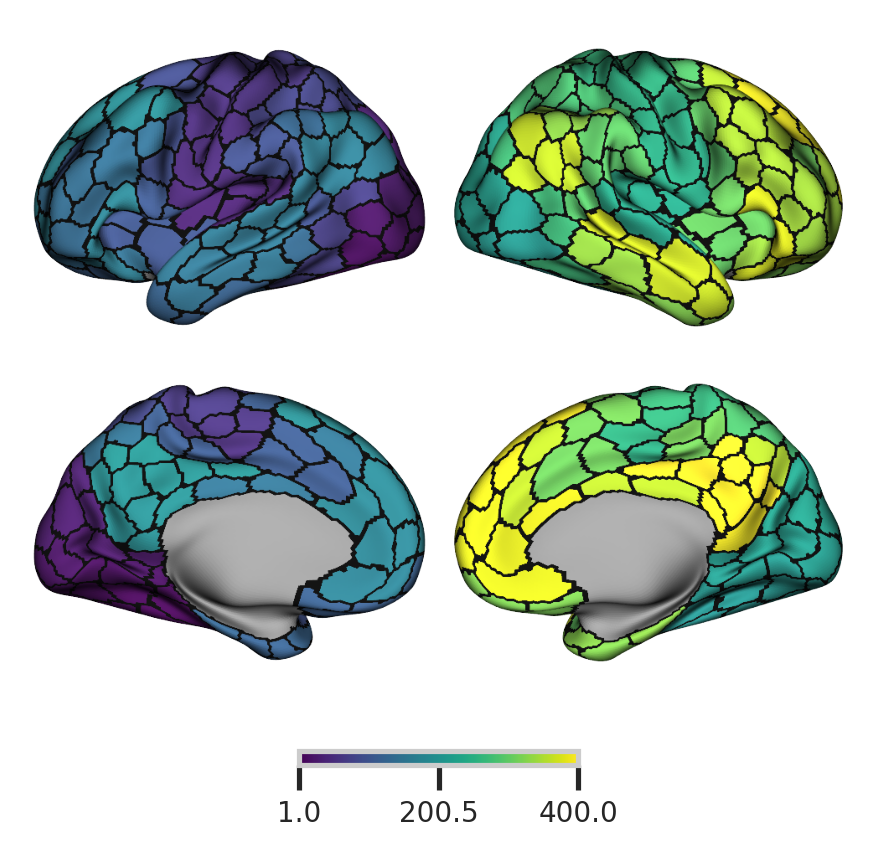

In [57]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=True)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = p.build()
fig.show()

In [58]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [59]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region":[],"value":[],"Hemisphere":[]}

vis_df = stab_df
value_column = "age_star"

for i, row in vis_df.iterrows():
    label = row[region_col]
    value = row[value_column]
    # if (row["p_corrected"] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
    if row["clipped"]:
        value = np.nan
    # else:
    #     value = np.nan
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            value_map[label] = value

vec = np.vectorize(lambda x: value_map.get(x, np.nan))
data_lh = vec(lh_parc)
data_rh = vec(rh_parc)

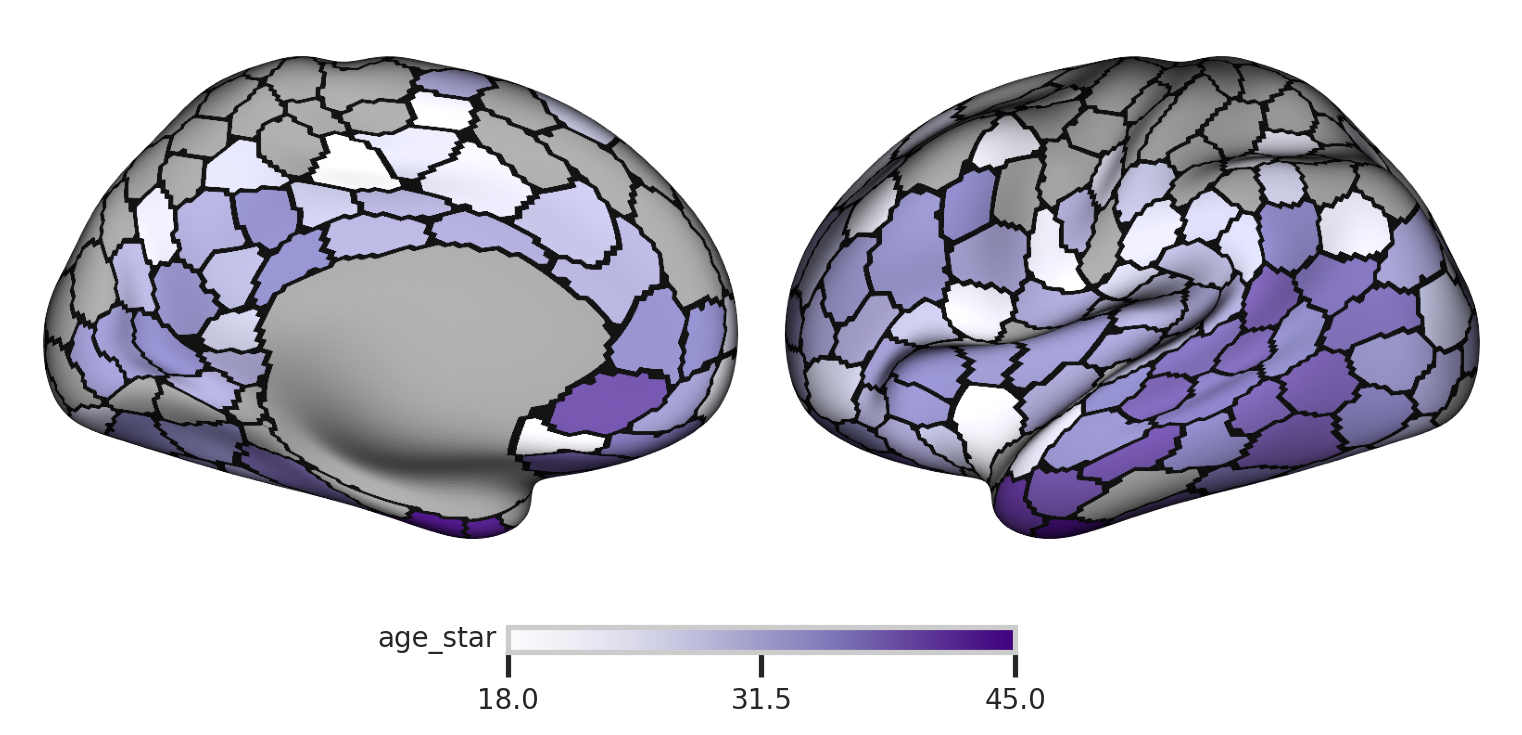

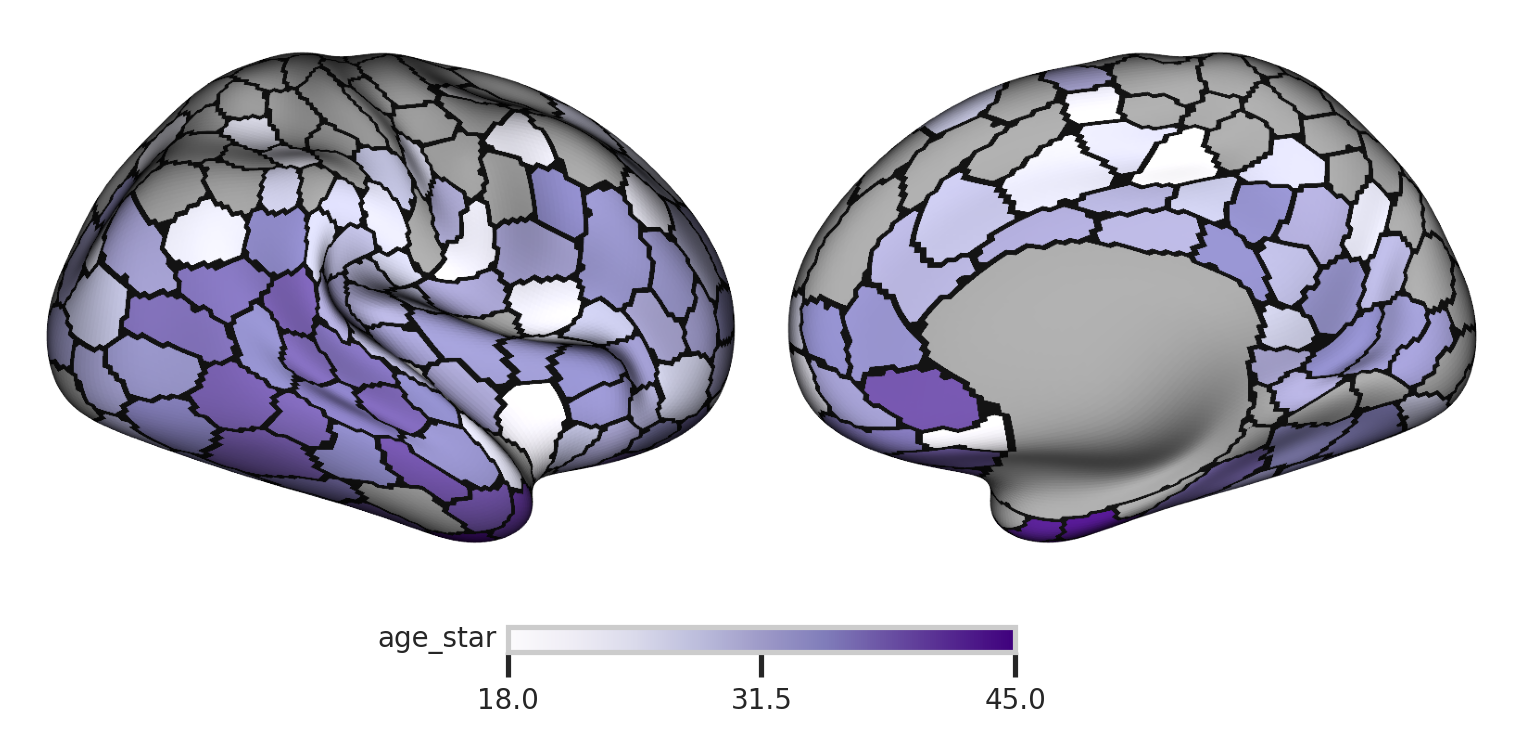

In [60]:
vmin = 18
vmax = 45

for hemi, hemi_data, key, vis_data in zip(["L","R"],[lh,rh], ["left","right"], [data_lh, data_rh]):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    p = Plot(
        hemi_data,
        # rh,
        # views="latmed",  # L-lat, L-med, R-lat, R-med
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",
        mirror_views=True,
        views=["medial","lateral"]
    )

    # ---- main data layer -------------------------------------------------
    # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
    # norm = TwoSlopeNorm(
    #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
    # )

    p.add_layer(
        {"left": data_lh, "right": data_rh},
        cmap="Purples",
        color_range=(vmin,vmax),
        # color_range=(2.5,3.5),
        cbar_label=value_column,
    )
    # ---- outline layer ---------------------------------------------------
    # Re-use the label arrays; surfplot draws borders when as_outline=True
    p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)


    # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
    fig = p.build()

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig3_{metric}_{hemi}_{value_column}.png", dpi=400)

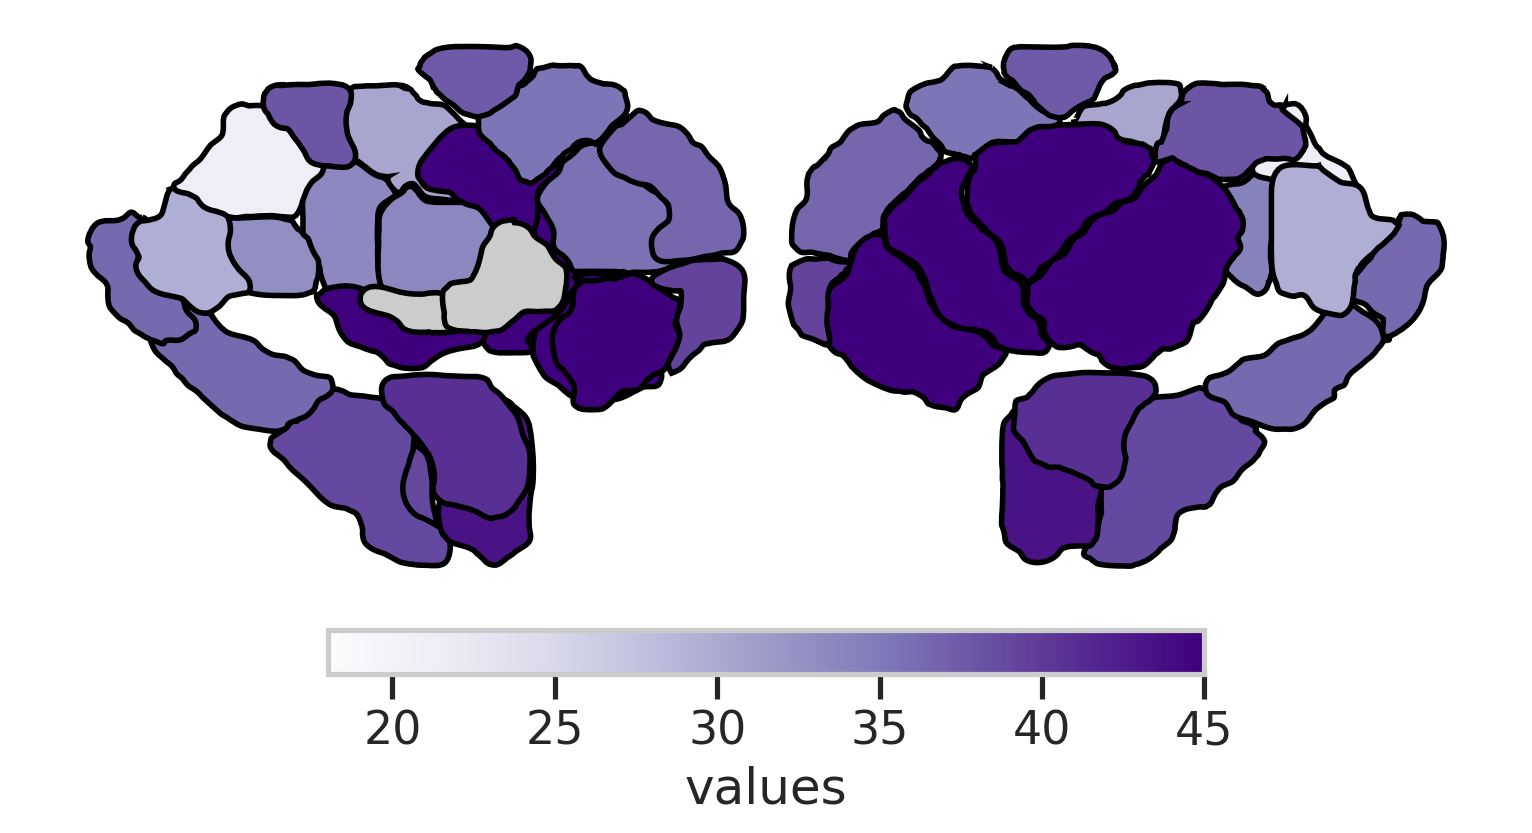

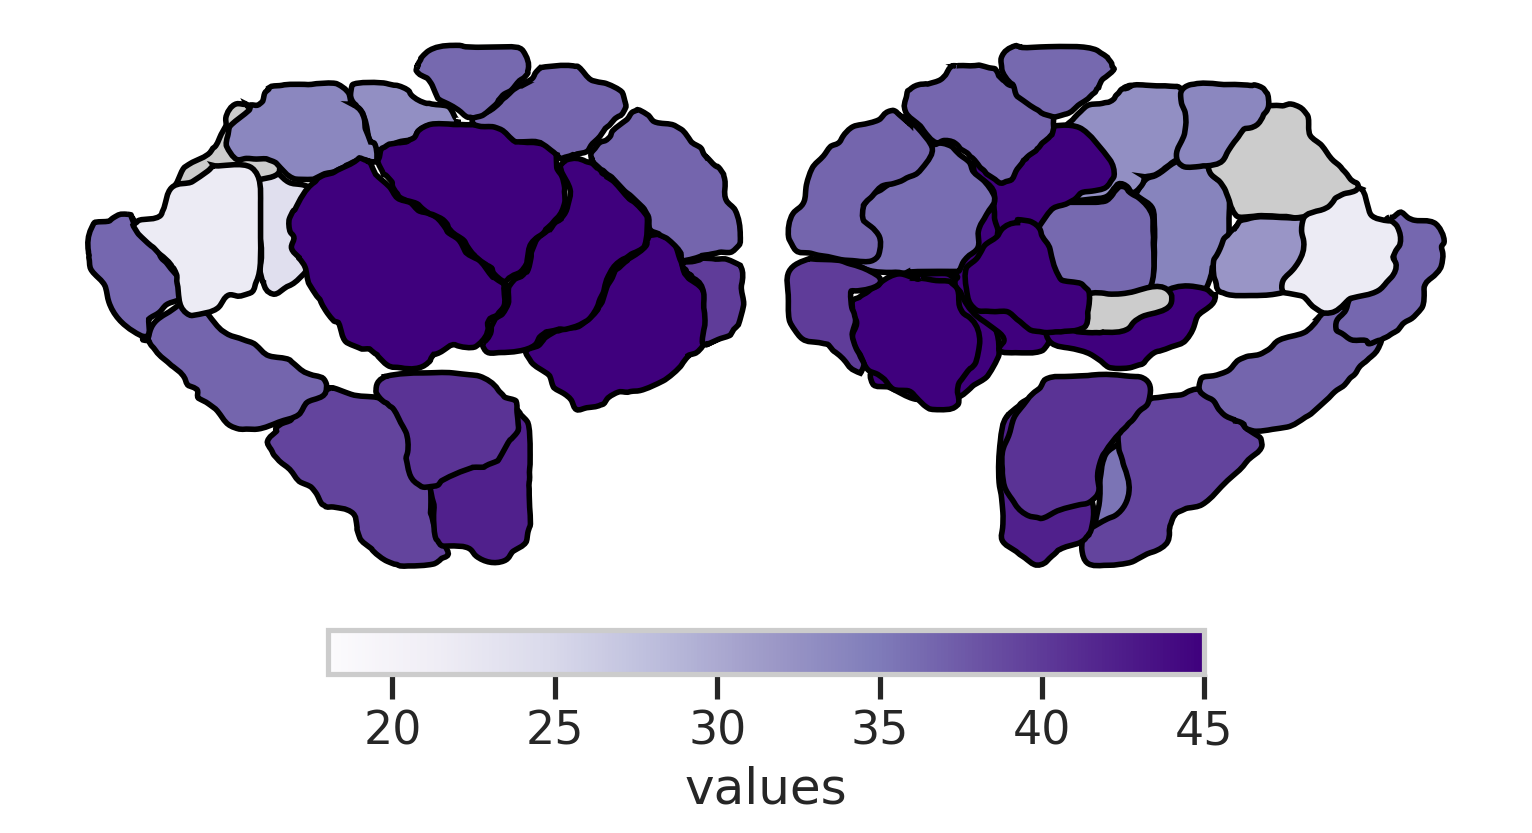

In [61]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L","R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="Purples",
        line_color="black",
        line_thickness=2,
        vmin = vmin,
        vmax = vmax,
        show_figure=False
    )

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)


In [63]:
stab_df[stab_df["clipped"] == False].sort_values("age_star", ascending=False).head(20)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
413,414,PUT-DA-rh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,R,55.957622,False,quadratic,4.046007e-16,-2.961982e-06,2.646630e-08,0.030586,0.062170
412,413,PUT-VA-rh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,R,55.595896,False,quadratic,2.033628e-22,-2.298223e-06,2.066899e-08,0.036254,0.081041
118,119,7Networks_LH_Limbic_TempPole_1,7networks_lh_limbic_temppole,7Networks_LH_Limbic_TempPole,limbic,temporal pole,L,55.431994,False,quadratic,4.252251e-02,-7.506675e-07,6.771067e-09,0.002744,0.004384
415,416,PUT-DP-rh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,R,54.103076,False,quadratic,8.907058e-18,-3.349901e-06,3.095851e-08,0.036461,0.071393
426,427,aGP-rh,aGP,"Pallidum, anterior part",subcortex,Pallidum,R,53.842908,False,quadratic,1.901007e-08,-4.424240e-06,4.108471e-08,0.009714,0.025075
423,424,NAc-shell-rh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,R,53.167680,False,quadratic,6.156658e-41,-3.151102e-06,2.963362e-08,0.029798,0.113565
439,440,PUT-VA-lh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,L,52.939843,False,quadratic,2.276913e-30,-3.000655e-06,2.834024e-08,0.028288,0.090273
442,443,PUT-DP-lh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,L,52.059687,False,quadratic,1.128058e-10,-2.449469e-06,2.352558e-08,0.018634,0.038710
440,441,PUT-DA-lh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,L,49.793722,False,quadratic,9.783332e-18,-2.574677e-06,2.585343e-08,0.004858,0.040840
450,451,NAc-shell-lh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,L,47.575736,False,quadratic,2.481058e-65,-4.257764e-06,4.474722e-08,0.003106,0.139137


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib import font_manager as fm

# template colour palette
COL_GREY = "#575A5C"  # primary charcoal (axes / default bars)
COL_TEAL = "#21A0A0"  # accent / second category
COL_GRID = "#E5E5E5"  # light gridlines
COL_SAME = "#D81B60"  # Deep pink/magenta
# COL_SAME = COL_GREY
# COL_DIFF_REP = "#1E88E5"  # Blue for diff subj (repeated)
COL_DIFF_REP = COL_TEAL
# COL_DIFF_SINGLE = "#43A047"  # Green for diff subj (single)
COL_DIFF_SINGLE = COL_GREY  # Green for diff subj (single)

In [152]:
i = 413
age_min = 18
age_max = 85
n_grid = 100

age_col = "age_at_scan"

d = data[data[region_col] == parcels.loc[i, region_col]].copy()

lm_res = models["lin_w"].loc[i,"model"]
qm_res = models["quad_w"].loc[i, "model"]
stab_row = stab_df.loc[i]
age_star = stab_row["age_star"]

# ── 3. Prediction grid ──────────────────────────────────────────────
age_grid = np.linspace(age_min, age_max, n_grid)
grid_df = pd.DataFrame({age_col: age_grid, "age_squared": age_grid ** 2})

# add any covariates present in models (use median/mode)
covs = [v for v in qm_res.model.exog_names if v not in ["Intercept", age_col, "age_squared"]]
for c in covs:
    if pd.api.types.is_numeric_dtype(data[c]):
        grid_df[c] = d[c].median()
    else:
        grid_df[c] = d[c].mode()[0]

In [153]:
# predictions
def pred_ci(model):
    pr = model.get_prediction(grid_df)
    ci = pr.conf_int(alpha=0.05)
    return pr.predicted_mean, ci[:, 0], ci[:, 1]


fit_lin, lo_lin, hi_lin = pred_ci(lm_res)
fit_quad, lo_quad, hi_quad = pred_ci(qm_res)

(0.00036080126405744497, 0.0008791290586740551)

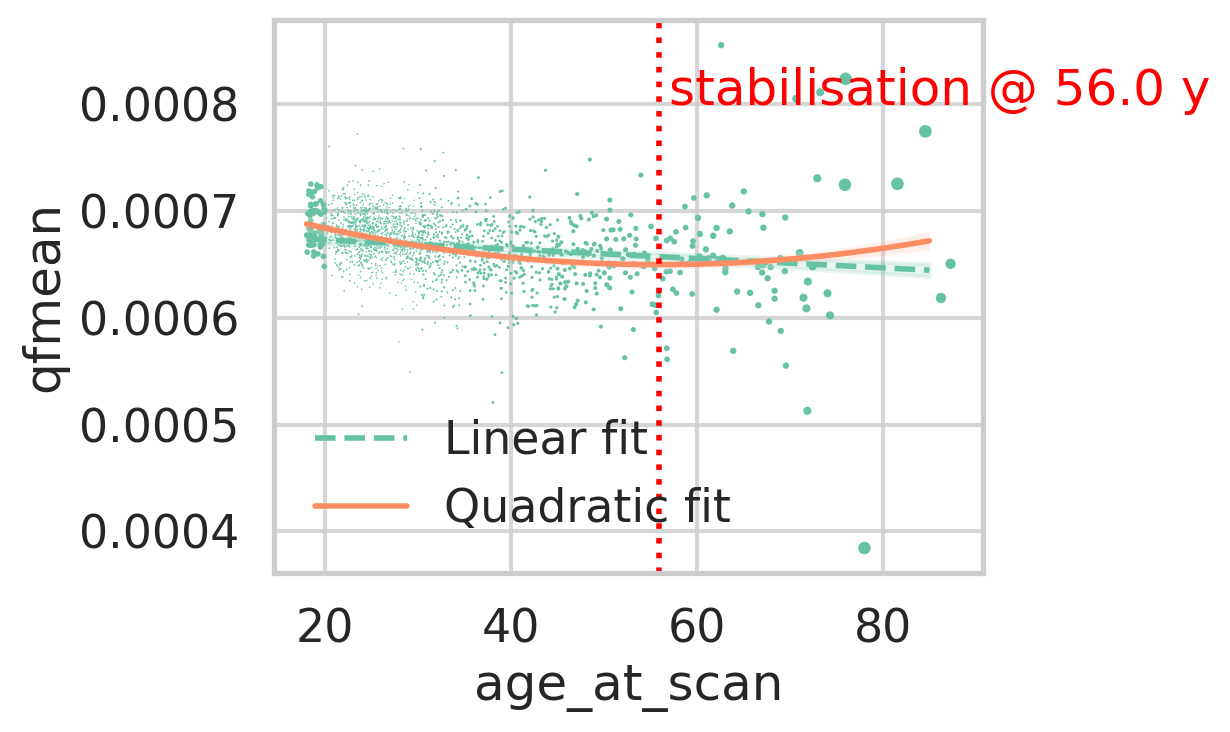

In [155]:
weight_col = "weight"
# ── 4. Plot ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 4))

# scatter of raw points
size_kw = {} if weight_col is None else {"s":  d[weight_col]}
sns.scatterplot(
    data=d,
    x=age_col,
    y=metric_col,
    # alpha=scatter_alpha,
    edgecolor="none",
    ax=ax,
    legend=False,
    **size_kw,
)

# linear fit
ax.plot(age_grid, fit_lin, ls="--", lw=2, label="Linear fit")
ax.fill_between(age_grid, lo_lin, hi_lin, alpha=0.15, color="C0")

# quadratic fit
ax.plot(age_grid, fit_quad, lw=2, label="Quadratic fit")
ax.fill_between(age_grid, lo_quad, hi_quad, alpha=0.15)

# stabilisation age
ax.axvline(age_star, ls=":", lw=2, color="red")
ax.text(
    age_star + 1,
    ax.get_ylim()[1] * 0.95,
    f"stabilisation @ {age_star:.1f} y",
    color="red",
    va="top",
)

# ax.set(xlabel="Age (years)", ylabel=f"{metric} value", title=f"Region {region_id} • {metric}")
ax.legend(frameon=False)
fig.tight_layout()
ax.set_ylim(
    # ax.get_ylim()[0] * 0.95,
    # ax.get_ylim()[1] * 1.05,
    # 0.0005,0.0008
)

In [ ]:
# ── Helper: per-region demonstration plot ──────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_region_fit(
    region_id,
    metric,
    df_long,
    *,
    lm_dict,
    qm_dict,
    stab_df,
    age_col="age_at_scan",
    value_col="value",
    weight_col=None,  # set to "weight" if you want weighted sizes
    age_min=18,
    age_max=85,
    n_grid=300,
    scatter_alpha=0.25,
):
    """
    Parameters
    ----------
    region_id   : hashable region label used in lm_dict / qm_dict keys
    metric      : str, metric name (e.g. "gm_vol" or "adc")
    df_long     : DataFrame with columns [region_id, age_col, value_col, weight_col]
    lm_dict     : {region_id: statsmodels.RegressionResults}  (linear fits)
    qm_dict     : {region_id: statsmodels.RegressionResults}  (quadratic fits)
    stab_df     : DataFrame with columns ['region', 'stabilisation_age', 'model']
    weight_col  : if not None, point size ∝ weight
    """
    # ── 1. Slice data for this region ────────────────────────────────────
    d = df_long[df_long["region"] == region_id].copy()

    # ── 2. Retrieve models & stabilisation age ──────────────────────────
    lm_res = lm_dict[region_id]
    qm_res = qm_dict[region_id]
    stab_row = stab_df.loc[stab_df["region"] == region_id].iloc[0]
    age_star = stab_row["age_star"]

    # ── 3. Prediction grid ──────────────────────────────────────────────
    age_grid = np.linspace(age_min, age_max, n_grid)
    grid_df = pd.DataFrame({age_col: age_grid})

    # add any covariates present in models (use median/mode)
    covs = [
        v for v in lm_res.model.exog_names if v not in ["Intercept", age_col, f"I({age_col} ** 2)"]
    ]
    for c in covs:
        if pd.api.types.is_numeric_dtype(df_long[c]):
            grid_df[c] = df_long[c].median()
        else:
            grid_df[c] = df_long[c].mode()[0]

    # predictions
    def pred_ci(model):
        pr = model.get_prediction(grid_df)
        ci = pr.conf_int(alpha=0.05)
        return pr.predicted_mean, ci[:, 0], ci[:, 1]

    fit_lin, lo_lin, hi_lin = pred_ci(lm_res)
    fit_quad, lo_quad, hi_quad = pred_ci(qm_res)

    # ── 4. Plot ─────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 4))

    # scatter of raw points
    size_kw = {} if weight_col is None else {"s": 30 * d[weight_col]}
    sns.scatterplot(
        data=d,
        x=age_col,
        y=value_col,
        alpha=scatter_alpha,
        edgecolor="none",
        ax=ax,
        legend=False,
        **size_kw,
    )

    # linear fit
    ax.plot(age_grid, fit_lin, ls="--", lw=2, label="Linear fit")
    ax.fill_between(age_grid, lo_lin, hi_lin, alpha=0.15)

    # quadratic fit
    ax.plot(age_grid, fit_quad, lw=2, label="Quadratic fit")
    ax.fill_between(age_grid, lo_quad, hi_quad, alpha=0.15)

    # stabilisation age
    ax.axvline(age_star, ls=":", lw=2, color="red")
    ax.text(
        age_star + 1,
        ax.get_ylim()[1] * 0.95,
        f"stabilisation @ {age_star:.1f} y",
        color="red",
        va="top",
    )

    ax.set(xlabel="Age (years)", ylabel=f"{metric} value", title=f"Region {region_id} • {metric}")
    ax.legend(frameon=False)
    fig.tight_layout()
    return fig, ax

